# AcneScan App Machine Learning

## Import Library

In [2]:
import tensorflow as tf
import os
import random
from sklearn.metrics import f1_score
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from io import BytesIO
# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from ipywidgets import widgets
from PIL import Image

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15294675586204511544
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1733715559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13445198788039781673
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Mounting Data From Google Drive

## Collecting Data from Directory

In [5]:
TRAIN_DIR = './acnedata/acne_dataset_2/train/'
VAL_DIR = './acnedata/acne_dataset_2/valid/'
TEST_DIR = './acnedata/acne_dataset_2/test/'

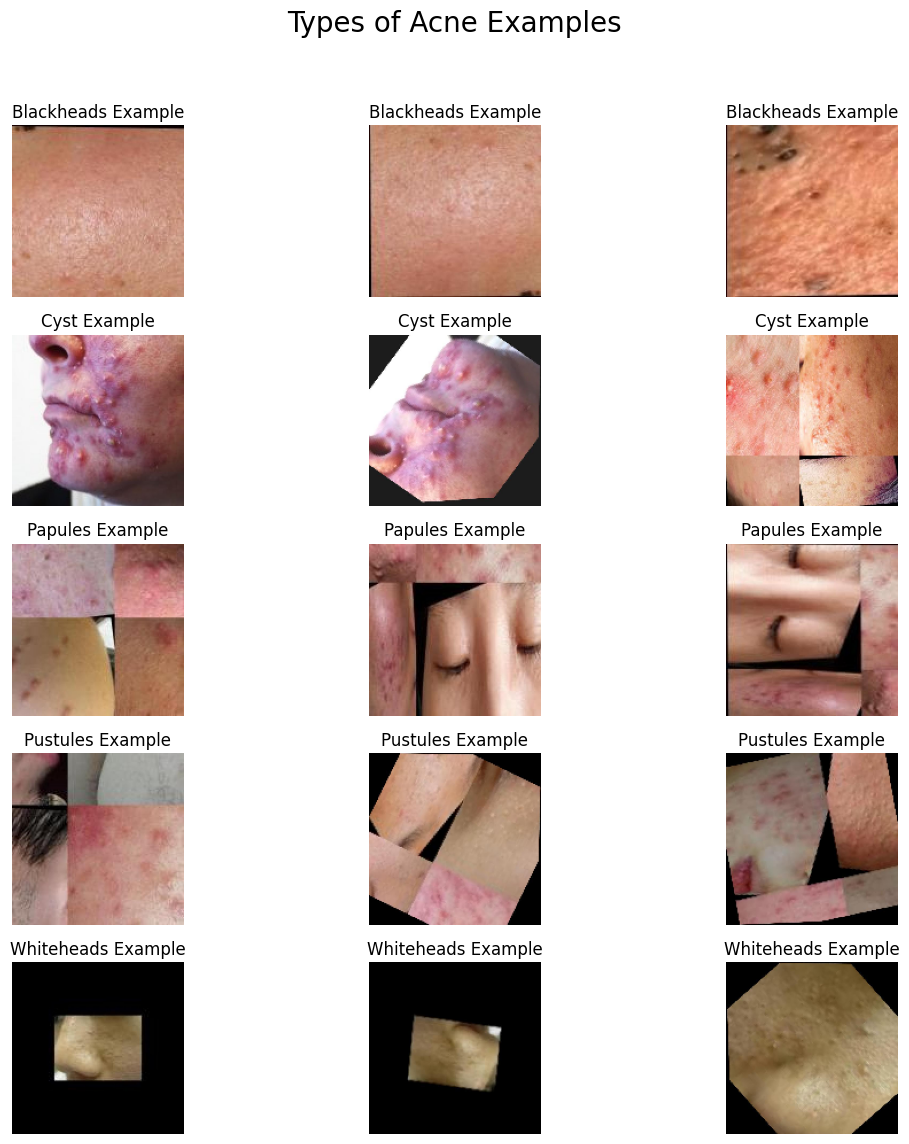

In [6]:
categories = ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']

fig, axes = plt.subplots(len(categories), 3 , figsize=(12, 12))
plt.suptitle("Types of Acne Examples", fontsize=20)

for i, category in enumerate(categories):
  category_path = os.path.join(TRAIN_DIR, category)
  images = os.listdir(category_path)[:3]
  for j, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{category} Example')
        axes[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has shape{sample_array.shape}")

Each image has shape(150, 150, 3)


In [8]:
sample_array[0,:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

## Creating datasets for the CNN

In [9]:
def train_val_test_dataset():
    """
    Create train, validation, and test datasets.

    Returns:
    (tf.data.Dataset, tf.data.Dataset, tf.data.Dataset): train, validation, and test datasets
    """
    # Load train and validation directories
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
        shuffle=True
    )

    # Load entire validation dataset from VAL_DIR
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=VAL_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
    )
    
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
    )

    
    # Optimize performance with caching and prefetching
    train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset


In [10]:
train_dataset, val_dataset, test_dataset = train_val_test_dataset()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {val_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {val_dataset.element_spec[1].shape}")

Found 2768 files belonging to 5 classes.
Found 921 files belonging to 5 classes.
Found 918 files belonging to 5 classes.
Images of train dataset have shape: (None, 150, 150, 3)
Labels of train dataset have shape: (None, 5)
Images of validation dataset have shape: (None, 150, 150, 3)
Labels of validation dataset have shape: (None, 5)


## Create and Compile Model

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Subtler rotation
    layers.RandomZoom(height_factor=0.1),  # Moderate zoom
    layers.RandomBrightness(0.1),  # Adjust brightness
    layers.RandomContrast(0.2),  # Higher contrast adjustment
    layers.GaussianNoise(0.02),  # Slightly increased noise
    layers.Resizing(height=150, width=150)  # Resize for EfficientNet
])


In [12]:
# # create function create_model with sequential CNN architecture

# def create_model():
#   """
#   Creates a CNN model with a sequential architecture.

#   Returns:
#     A tf.keras.Model object.
#   """
#   model = tf.keras.Sequential([
#         tf.keras.Input(shape=(120, 120, 3)),
#         tf.keras.layers.Rescaling(1./255),
#         data_augmentation,

#         layers.Conv2D(32, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.3),

#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.3),

#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.4),

#         layers.Flatten(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(7, activation='softmax')
#     ])

#   model.compile(
#       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#       loss='categorical_crossentropy',
#       metrics=['accuracy']
#   )

#   return model

In [13]:
def create_efficientnet_model():
    """
    Creates a CNN model using EfficientNetB0 for transfer learning.

    Returns:
        A tf.keras.Model object.
    """
    # Load EfficientNetB0 with pre-trained weights and without the top classification layer
    efficientnet_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )

    # Freeze the layers of EfficientNet initially
    for layer in efficientnet_model.layers[:-50]:  # Freeze most layers initially
        layer.trainable = True

    # Build the custom model on top of EfficientNetB0
    input_layer = layers.Input(shape=(150, 150, 3))
    x = data_augmentation(input_layer)
    x = efficientnet_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
  )

    return model

In [14]:
# def create_resnet_model():
#     """
#     Creates a CNN model using ResNet50 for transfer learning.

#     Returns:
#         A tf.keras.Model object.
#     """
#     # Load ResNet50 with pre-trained weights and without the top classification layer
#     resnet_model = tf.keras.applications.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(120, 120, 3)
#     )

#     # Freeze the layers of ResNet initially
#     for layer in resnet_model.layers:
#         layer.trainable = False

#     # Build the custom model on top of ResNet50
#     input_layer = layers.Input(shape=(120, 120, 3))
#     x = data_augmentation(input_layer)  # Apply data augmentation
#     x = resnet_model(input_layer, training=False)  # Ensure layers are in inference mode during initial training
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(1024, activation='relu')(x)
#     # x = layers.BatchNormalization()(x)  # Optional, for stability
#     x = layers.Dropout(0.5)(x)  # Adjust dropout rate based on performance
#     output_layer = layers.Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

#     model = Model(inputs=input_layer, outputs=output_layer)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [15]:
model = create_efficientnet_model()

In [16]:
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Input shape: (None, 150, 150, 3)
Output shape: (None, 5)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                               

Check that the architecture is compatible with dataset

In [18]:
example_batch_images, example_batch_labels = next(iter(train_dataset))

try:
    model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
    print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
    predictions = model.predict(example_batch_images, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [19]:
        from sklearn.utils import class_weight

        # Extract class labels from the dataset
        class_labels = []
        for images, labels in train_dataset:
            class_labels.append(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to class indices

        # Flatten the list of class labels
        class_labels = np.concatenate(class_labels)

        # Compute class weights
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(class_labels),
            y=class_labels
        )

        # Convert to dictionary for use in model.fit
        class_weights = dict(enumerate(class_weights))
        print(class_weights)


{0: 0.7531972789115646, 1: 0.8718110236220472, 2: 0.8914653784219002, 3: 0.947945205479452, 4: 2.8683937823834196}


In [20]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

# Add the callbacks to the fit function:
with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=110,
        validation_data=val_dataset,
        callbacks=[lr_scheduler, early_stopping],
        class_weight=class_weights
    )

Epoch 1/110
87/87 [==============================] - 75s 679ms/step - loss: 5.6975 - accuracy: 0.2973 - precision: 0.3168 - recall: 0.2428 - val_loss: 4.7756 - val_accuracy: 0.4636 - val_precision: 0.7917 - val_recall: 0.1444 - lr: 1.0000e-04
Epoch 2/110
87/87 [==============================] - 60s 690ms/step - loss: 5.1017 - accuracy: 0.4137 - precision: 0.4564 - recall: 0.3559 - val_loss: 4.4405 - val_accuracy: 0.5624 - val_precision: 0.7890 - val_recall: 0.3572 - lr: 1.0000e-04
Epoch 3/110
87/87 [==============================] - 61s 699ms/step - loss: 4.6913 - accuracy: 0.5014 - precision: 0.5582 - recall: 0.4451 - val_loss: 4.6679 - val_accuracy: 0.4810 - val_precision: 0.5381 - val_recall: 0.4528 - lr: 1.0000e-04
Epoch 4/110
87/87 [==============================] - 59s 676ms/step - loss: 4.4446 - accuracy: 0.5625 - precision: 0.6120 - recall: 0.5065 - val_loss: 4.3941 - val_accuracy: 0.5744 - val_precision: 0.7007 - val_recall: 0.4549 - lr: 1.0000e-04
Epoch 5/110
87/87 [=========

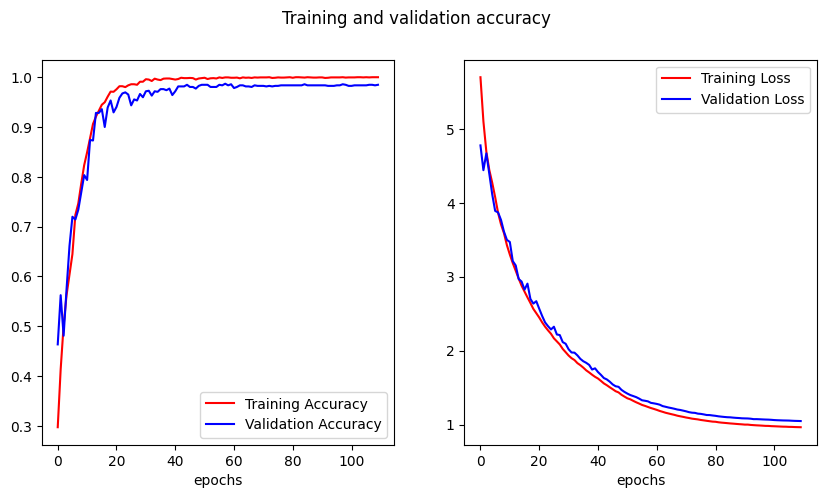

In [21]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Evaluate the Model

In [22]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},\nTest Accuracy:: {test_accuracy},\nTest Precision:: {test_precision},\nTest Recall:: {test_recall}")

29/29 [==============================] - 3s 83ms/step - loss: 1.0452 - accuracy: 0.9815 - precision: 0.9814 - recall: 0.9782
Test Loss: 1.0452214479446411,
Test Accuracy:: 0.9814814925193787,
Test Precision:: 0.9814207553863525,
Test Recall:: 0.9782134890556335


## Test the Model

29/29 [==============================] - 3s 50ms/step
Test Set F1 Score: 0.982353754593064


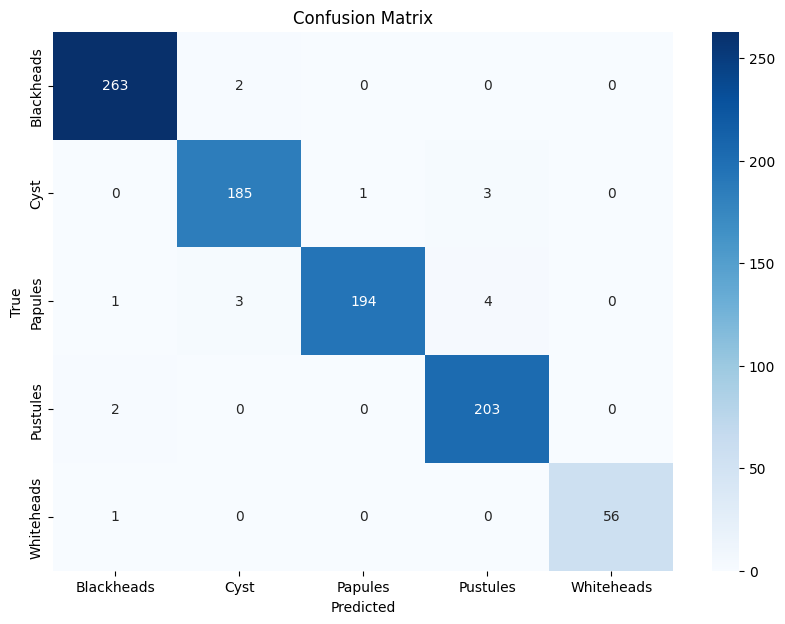

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define categories
categories = categories

# Get predictions and true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Calculate F1 score
f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
print(f"Test Set F1 Score: {f1}")

# Generate confusion matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 28ms/step


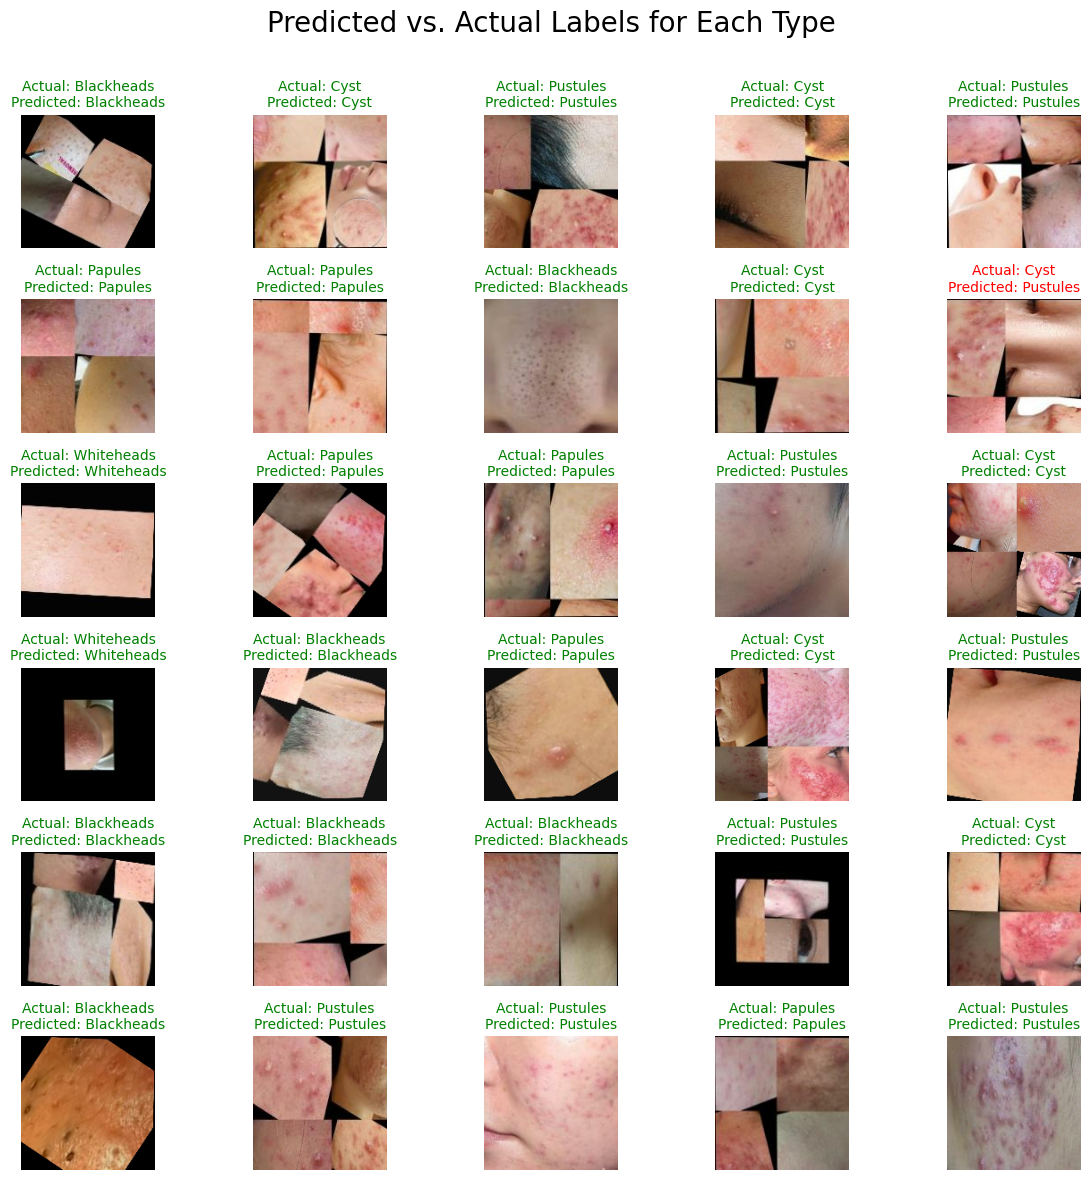

In [24]:
# Get a batch of images and labels
images, labels = next(iter(test_dataset))

# Predict labels for the batch of images
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(labels, axis=1)


images = images / 255.0
# Initialize a figure to plot
fig, axes = plt.subplots(6, 5, figsize=(12, 12))  # Adjust number of columns for layout
fig.suptitle("Predicted vs. Actual Labels for Each Type", fontsize=20)

# Display images per category
for idx, ax in enumerate(axes.flat):
    if idx >= len(images):
        ax.axis('off')
        continue

    actual_category = categories[actual_labels[idx]]
    predicted_category = categories[predicted_labels[idx]]

    # Determine title color based on prediction accuracy
    color = 'green' if actual_category == predicted_category else 'red'

    # Plot the image and adjust its display
    ax.imshow(images[idx].numpy().squeeze())
    ax.set_title(f"Actual: {actual_category}\nPredicted: {predicted_category}", fontsize=10, color=color)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make space for title
plt.show()

In [25]:
def predict_custom_image(image_path, model, categories):
    """
    Make predictions on a custom image, aligned with your training setup.
    
    Parameters:
    image_path (str): Path to the image file
    model: Trained EfficientNetB0-based model
    categories (list): List of category names
    
    Returns:
    tuple: (predicted_category, confidence_score, preprocessed_image)
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to match your training size (120x120)
        img = img.resize((150, 150))
        
        # Convert to array
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Normalize pixel values (matching EfficientNetB0 preprocessing)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        
        # Get top 3 predictions for analysis
        top_3_indices = np.argsort(predictions[0])[-3:][::-1]
        print("\nTop 3 predictions:")
        for idx in top_3_indices:
            print(f"{categories[idx]}: {predictions[0][idx]:.2%}")
            
        predicted_class_index = np.argmax(predictions[0])
        confidence_score = float(predictions[0][predicted_class_index])
        
        return categories[predicted_class_index], confidence_score, img_array[0]
    
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None, None

def display_prediction(image_path, model, categories):
    """
    Display the original image with its prediction and confidence score.
    """
    predicted_category, confidence_score, _ = predict_custom_image(image_path, model, categories)
    
    if predicted_category is not None:
        # Load and display original image
        img = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence_score:.2%}", 
                 fontsize=12, pad=20)
        plt.show()
        
        # Print detailed analysis
        print(f"\nDetailed Analysis:")
        print(f"Predicted Category: {predicted_category}")
        print(f"Confidence Score: {confidence_score:.2%}")


Top 3 predictions:
Pustules: 99.91%
Whiteheads: 0.05%
Papules: 0.03%


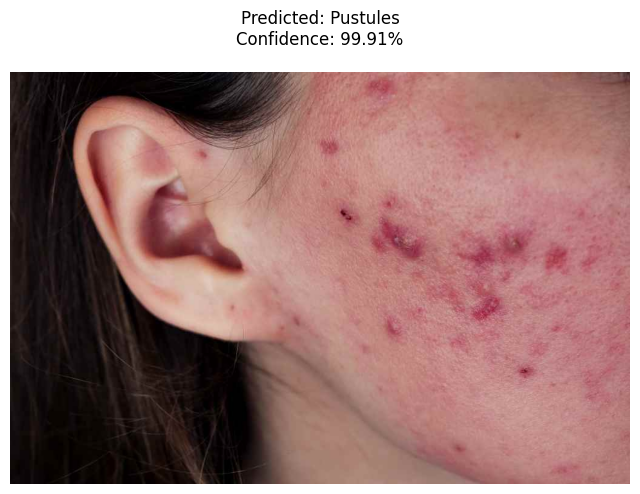


Detailed Analysis:
Predicted Category: Pustules
Confidence Score: 99.91%


In [29]:
# Example usage
image_path = "jerawat-pustula-doktersehat.jpg"
display_prediction(image_path, model, categories)

In [ ]:
# model.save('best_model2.keras')

In [ ]:
# # Load the saved model (optional if already in memory)
# model = tf.keras.models.load_model("best_model2.keras")

# # Convert to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open("best_model2.tflite", "wb") as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\hadin\AppData\Local\Temp\tmpmfisi8au\assets


INFO:tensorflow:Assets written to: C:\Users\hadin\AppData\Local\Temp\tmpmfisi8au\assets
